## In-depth Exploratory Data Analysis

With wildfires at the center of our interests, we want to understand how their presence and prevalence affects travel and mobility around the Bay Area by looking at five sets of factors. Most of these have aggregations by county and zip code between 2015 and 2020:
- Wildfire occurence - a boolean value indicating whether or not a fire happened
- Air quality statistics - descriptive measures and aggregates to indicate air quality levels across different Bay Area locations
- AirBnB vacancies - the vacancy rate of AirBnB facilities for days based on the proportion of properties that are available for booking versus all booked and vacant properties
- Google mobility data - this information, collected by Google throughout 2020 during the rise of COVID-19 shows measures of value and activity in parks and recreation, groceries, and transit among other indicators.
- Airport traffic - all domestic travel into the main Bay Area airports. This data is given quarterly as opposed to daily for every other data source


For explorations, we will look at zip code data first as it is more granular.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#file/drive paths
#change the subpath to match your drive location
subpath = '/content/drive/MyDrive/2020-Move/Learning'
path = subpath+'/DS4A-correlation-one/DS4A Project/repo/data/'

In [ ]:
#modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
from scipy.stats import skew

#feeling dangerous
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#load files
df_zipcodes_final = pd.read_csv(path+'aggregated_by_zip.csv').drop(columns=['STATION', 'ESTIMATED'])
df_counties_final = pd.read_csv(path+'aggregated_by_county.csv')

#for viewing dfs
def see_df(df):
  print(df.columns)
  print('\nData dimensions:', df.shape, '\n')
  return df.head(2)

In [ ]:
#data
see_df(df_zipcodes_final)

Index(['Zip Code', 'DATE', 'AVE_PM_2.5', 'MAX_PM_2.5', '24hr_AQI', 'Max_AQI',
       'Active_wildfires', 'Acres_per_day', 'Vacancy_Rate', 'COUNTY',
       'QUARTER'],
      dtype='object')

Data dimensions: (668560, 11) 



,Zip Code,DATE,AVE_PM_2.5,MAX_PM_2.5,24hr_AQI,Max_AQI,Active_wildfires,Acres_per_day,Vacancy_Rate,COUNTY,QUARTER
0,94002,2015-01-01,14.708333,40.0,56,112,False,NaN,NaN,San Mateo,Q1 of 2015
1,94002,2015-01-02,15.500000,25.0,58,78,False,NaN,NaN,San Mateo,Q1 of 2015


## 1. Feature Distributions & Transformations

To appropriately review the variables' relationships, first we identify which ones are numeric and which are categorical in order to transform any categories so their descriptive analysis is measurable and normalize any numerical features to get a more feasible sample representation.

### 1.1 One-Hot Encoding & Time Variables
Feature of interest: Wildfires - needs to be transformed into ordinal value for numerical interpretation. Date also needs to be a datetime object while Quarter should be stored as a DateQuarter object

In [ ]:
#split variable types
cat_features = ['Zip Code', 'DATE', 'COUNTY', 'Active_wildfires', 'QUARTER']
num_features = ['AVE_PM_2.5', 'MAX_PM_2.5', '24hr_AQI', 'Max_AQI',  'Acres_per_day', 'Vacancy_Rate']

In [ ]:
#time variables
df_zipcodes_final['DATE'] = pd.to_datetime(df_zipcodes_final['DATE'])
#df_zipcodes_final['QUARTER'] = DateQuarter()

In [ ]:
#one hot encode active wildfires
df_zipcodes_final['Active_wildfires'] = df_zipcodes_final['Active_wildfires'].apply(lambda x: 1 if x == True else 0)
df_zipcodes_final['Active_wildfires'].unique()

array([0, 1])

### 1.2 Distributions and Correlations
For the other categorical features, it would be more meaningful to explore them as is and for some, we cannot change them because they are also identifiers for the data e.g. date, quarter, location (zip and county). However, for our numerical features that are measures, we can review the distributions to understand which approaches would work for analysis.

#### 1.2.1 Numerical Features Correlations
- To note: some of these features are the same value aggregated in different ways e.g. any PM_2.5 or AQI suffixed values are the same measure.

In [ ]:
df_zipcodes_final[num_features + ['Active_wildfires']].corr()

,AVE_PM_2.5,MAX_PM_2.5,24hr_AQI,Max_AQI,Acres_per_day,Vacancy_Rate,Active_wildfires
AVE_PM_2.5,1.000000,0.851747,0.916057,0.786495,0.203851,0.047579,0.033154
MAX_PM_2.5,0.851747,1.000000,0.806624,0.923635,0.227943,0.059285,0.036735
24hr_AQI,0.916057,0.806624,1.000000,0.854144,0.238800,0.053942,0.031899
Max_AQI,0.786495,0.923635,0.854144,1.000000,0.230089,0.059981,0.031968
Acres_per_day,0.203851,0.227943,0.238800,0.230089,1.000000,0.569397,NaN
Vacancy_Rate,0.047579,0.059285,0.053942,0.059981,0.569397,1.000000,0.012143
Active_wildfires,0.033154,0.036735,0.031899,0.031968,NaN,0.012143,1.000000


**Some observations:**
- Unsurprisingly, the air quality and particulate matter measures are very strongly positively correlated in that there tends to be a higher air quality index when any of the particulate matter measured quantities increase. 
- There are no strong relationships between the vacancy rate and any air quality indicators. This may be something not necessarily associated with a customer's assessment of an AirBnB property or the location once they have selected the location - i.e. accomodation selection may be independent of location/destination selection so it would be hard to find a meaningful relationship with air quality as an instrumental variable.
- There is a positive correlation between the vacancy rates and the acres burnt per day when there are fires

#### 1.2.2 Distributions
Below we can observe how the values of each numerical feature are distributed, and if this changes depending on whether or not there is a wildfire.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


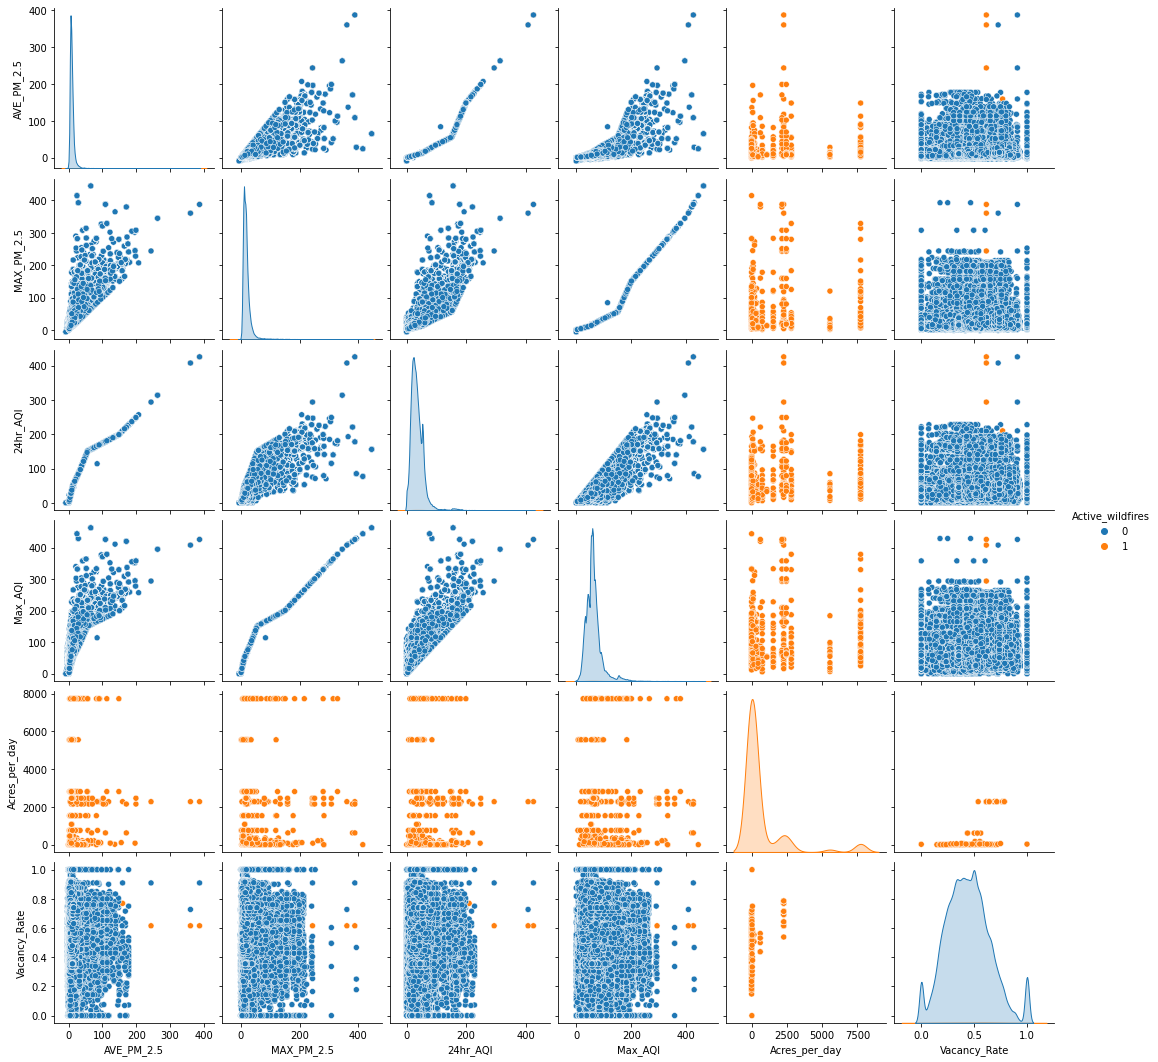

In [ ]:
#distributions = don't re-run this line unless you change the data. It takes a LOT of time to generate
sns.pairplot(df_zipcodes_final[num_features + ['Active_wildfires']], hue='Active_wildfires')
plt.show()

**Quick Hits**

- *Almost* all of the measures are right skewed. It is helpful to note again that these are either `air quality` or `particulate matter` measures. Additionally, the `acres per day` distribution also looks like the former, and is only available for the sample where a wildfire is recorded - this tracks because there would be nothing burning per day if there was no wildfire.
- Vacancy rate looks to be the closest distribution to normal with some peaks at the zero and maximum vacancy rate values (0 and 1).

### 1.3 Descriptive Statistics & Skewedness
Typically descriptive statistics help us get a quick sense of the values we have in our dataset. In this case, we are going to use the numerical descriptive values alongside the pairplot above to understand the degree of skewedness of our favorite variables. We can tell from the above plot that most of our data for air quality and PM2.5 is right skewed (positive skewed data). It might help us get a better view of it if we explore some transformations.

In [ ]:
df_zipcodes_final[num_features + ['Active_wildfires']].describe()

,AVE_PM_2.5,MAX_PM_2.5,24hr_AQI,Max_AQI,Acres_per_day,Vacancy_Rate,Active_wildfires
count,668560.000000,668560.000000,668560.000000,668560.000000,1127.000000,151897.000000,668560.000000
mean,9.151395,19.163936,34.349441,61.688791,707.897631,0.439974,0.001686
std,10.224558,19.037605,22.697380,30.160994,1734.580310,0.209911,0.041023
min,-8.750000,-6.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.750000,11.000000,20.000000,46.000000,0.274457,0.291667,0.000000
50%,7.260870,15.000000,30.000000,57.000000,3.368421,0.431111,0.000000
75%,10.666667,22.000000,44.000000,72.000000,207.500000,0.570833,0.000000
max,387.800000,445.000000,426.000000,463.000000,7728.085106,1.000000,1.000000


There are not a lot of negative values in the dataset from how the quantiles look which is good to know for the method we end up choosing to transform data by if any. Right away, we see that the **mean > median** for almost all these measures which tells us for sure that we have positive (right) skewed data. We can also find out to what degree this is. Visually, it looks very obvious that the PM2.5 and AQI are highly skewed while the vacancy rate is more evenly distributed. However, we can calculate the `sample skewness` to confirm our hunches.

In [ ]:
#skewedness for the numerical features (dropping na for quick view)
print('Features Sample Skewness:')
for feature in num_features:
  print(feature+':', skew(df_zipcodes_final[feature].dropna())) #dropna affects acres and vacancy rate values

Features Sample Skewness:
AVE_PM_2.5: 7.6163059887708835
MAX_PM_2.5: 6.697834703532847
24hr_AQI: 2.5846000953116226
Max_AQI: 2.4962275866436023
Acres_per_day: 3.0887093061527717
Vacancy_Rate: 0.35577964535120565


From the above, all variables but vacancy rate are highly skewed. Vacancy rate is shown to be moderately skewed when we don't account for missing values (more on that later). For this exploration of the skewed variables, we select a `logarithmic transformation`. 

To note: This will change the interpretation of the data points in relation to other variables as well.

In [ ]:
#log transform of AQI and PM2.5 data points
transform_features = ['AVE_PM_2.5', 'MAX_PM_2.5', '24hr_AQI', 'Max_AQI', 'Vacancy_Rate']
for feature in transform_features:
  df_zipcodes_final['log_'+feature] = np.log(df_zipcodes_final[feature])

see_df(df_zipcodes_final)

Index(['Zip Code', 'DATE', 'AVE_PM_2.5', 'MAX_PM_2.5', '24hr_AQI', 'Max_AQI',
       'Active_wildfires', 'Acres_per_day', 'Vacancy_Rate', 'COUNTY',
       'QUARTER', 'log_AVE_PM_2.5', 'log_MAX_PM_2.5', 'log_24hr_AQI',
       'log_Max_AQI', 'log_Vacancy_Rate'],
      dtype='object')

Data dimensions: (668560, 16) 



,Zip Code,DATE,AVE_PM_2.5,MAX_PM_2.5,24hr_AQI,Max_AQI,Active_wildfires,Acres_per_day,Vacancy_Rate,COUNTY,QUARTER,log_AVE_PM_2.5,log_MAX_PM_2.5,log_24hr_AQI,log_Max_AQI,log_Vacancy_Rate
0,94002,2015-01-01,14.708333,40.0,56,112,0,NaN,NaN,San Mateo,Q1 of 2015,2.688414,3.688879,4.025352,4.718499,NaN
1,94002,2015-01-02,15.500000,25.0,58,78,0,NaN,NaN,San Mateo,Q1 of 2015,2.740840,3.218876,4.060443,4.356709,NaN


Now to repeat the exercise of reviewing these variables against others

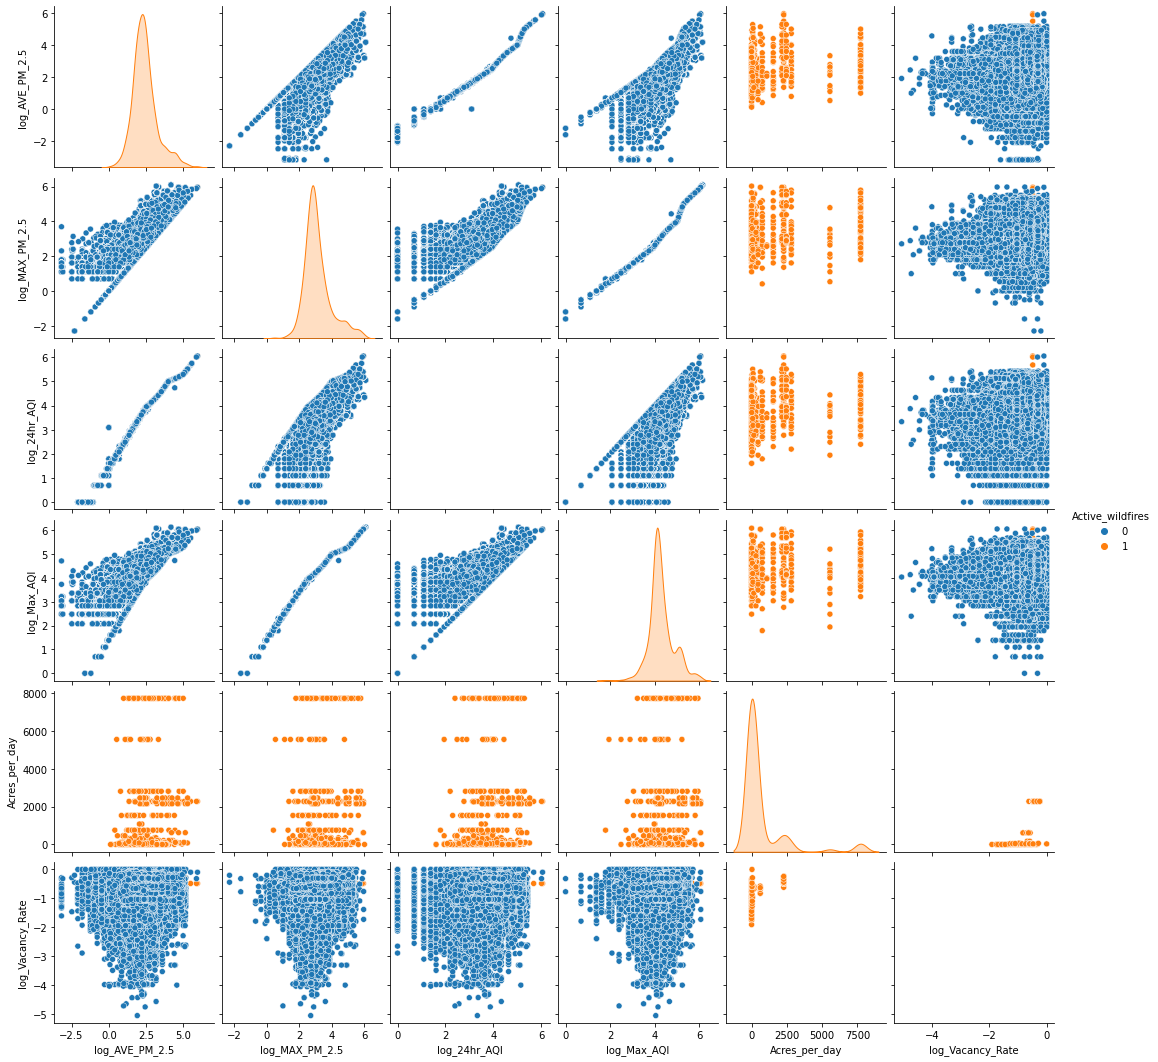

In [ ]:
#READ: pairplot with log transforms = don't re-run unless you changed values, takes a TON of time
sns.pairplot(df_zipcodes_final[['log_AVE_PM_2.5', 'log_MAX_PM_2.5', 'log_24hr_AQI','log_Max_AQI', 'Active_wildfires', 'Acres_per_day', 'log_Vacancy_Rate']],
             hue='Active_wildfires')
plt.show()

Although the variables we transformed are not exactly normally distributed, we get a better picture of how they change across the spectrum. We can also use this to see if there are any interesting relationships to model when combined with the categorical features. Also to note is that the transformation for `Vacancy_Rate` didn't work to display data most likely because we have missing values that need to be interpolated.

**Some concern:**

The data for this project as seen here is already an aggregation of even more granulated data. We aggregated it because of the project scope, so further summarizing it by doing some interpolation may add some spices we didn't know were in the food to begin with. Something to watch out for as we go.

### 1.4 Missing Values
As noted earlier, some of our metrics do not have all values. A quick summary below shows what is available and what isn't

In [ ]:
#see size versus missing values
print(df_zipcodes_final.shape, '\n')
df_zipcodes_final.isna().sum() #matches isnull() count

(668560, 11) 



Zip Code                 0
DATE                     0
AVE_PM_2.5               0
MAX_PM_2.5               0
24hr_AQI                 0
Max_AQI                  0
Active_wildfires      3660
Acres_per_day       667433
Vacancy_Rate        516663
COUNTY                   0
QUARTER                  0
dtype: int64

**Observations:**

- There are only three features with missing values. This is not surprising as we noted that this dataset is an aggregation of more granular location and time data
- `Vacancy Rate`: this is a proportion between 0 and 1. With most of the values missing, it would be pretty irresponsible to infer what values would be by looking at similar periods or timeframes and locations to determine fill values. For now, it may be wise to leave these as is.
- `Active_wildfires` and `Acres_per_day`: As we have explained prior, there will only be a value for acres burned if there is a prominent enough fire. Some fires do not have acres measured. Since these two features are conditional and based on unpredictable events (to our knowledge), it would also be a best practice to leave them alone and not try to fill in values given the nature of occurences.

## 2. Data Visualization

### 2.1 Changes over Time
All of our data has two reference features - time (by date or quarter for the airport data) and location (by zipcode and county). We are able to see if there are any time series characteristics like seasonality, outliers, and trends. We can explore this with most of our numeric features as follows: 

In [ ]:
df_zipcodes_final.columns

Index(['Zip Code', 'DATE', 'AVE_PM_2.5', 'MAX_PM_2.5', '24hr_AQI', 'Max_AQI',
       'Active_wildfires', 'Acres_per_day', 'Vacancy_Rate', 'COUNTY',
       'QUARTER'],
      dtype='object')

In [ ]:
#ALL PLOTS using these methods TAKE TIME TO RUN
#for line plots to see if there are any trends or outliers
def time_series_line_plots(var_list, df):
  fig, ax = plt.subplots(figsize=(24,5))
  for feature in var_list:
    sns.lineplot(x='DATE', y=feature, data=df)
    ax.set(title=' '.join(feature.split('_'))+' over Time', xlabel='Years', ylabel=' '.join(feature.split('_')))
  ax.xaxis_date()
  # legend and labels
  ax.set_xticklabels(ax.get_xticklabels(), ha='right', va='bottom', rotation=25)
  ax.xaxis.set_major_formatter(DateFormatter("%b-%Y"))
  ax.legend(var_list)
  plt.show()

#### 2.1.1 Wildfires and Acres Burned

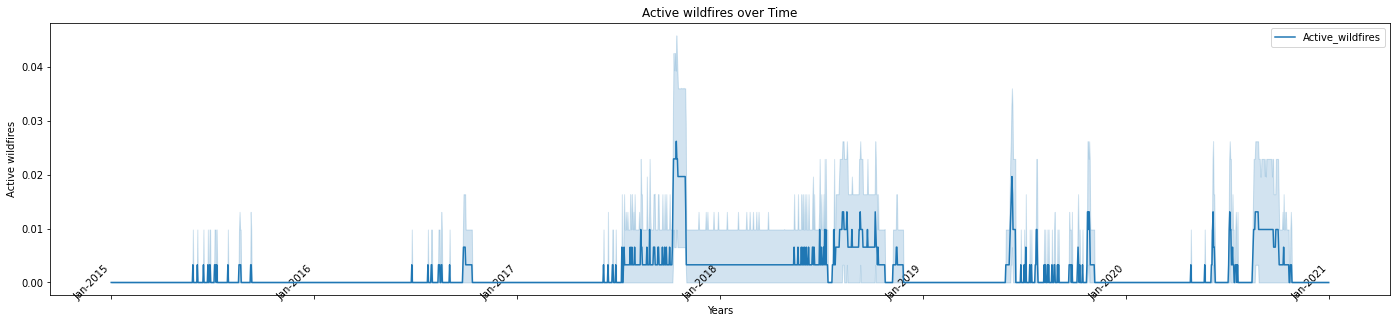

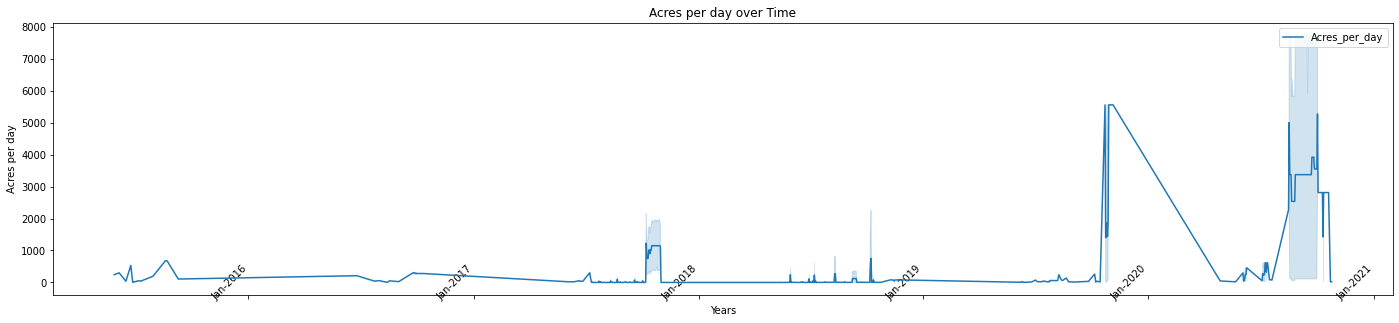

In [ ]:
#time series for main features - Wildfires
for feature in ['Active_wildfires', 'Acres_per_day']:
  time_series_line_plots([feature], df_zipcodes_final)

There is definitely some periodicity in when wildfires occur from the graphs above. There is no trend over this period of time, but if we narrow the exploration down to the seasonality seen towards the end of each year (when fires are occuring), we can see that there is an upward trend in acres burned in the last couple of years with what we hope to be an outlier in 2019-2020 transition. We cannot conclude that this is for sure a one time occurence with the volume of acres burnt as time will tell. 

With the active wildfires, there is an outlier in 2018 were active wildfires peaked in our period of interest. In terms of patterns, there is a small trend showing that the number of active wildfires during the seasons is increasing, but we don't know why there are very few acres burnt for the 2018 season with a high occurence rate. We speculate that there were little fires that were put out, but no large ones that impacted a large area or population

**Double check with Anja

#### 2.1.2 AirBnB Vacancy Rate

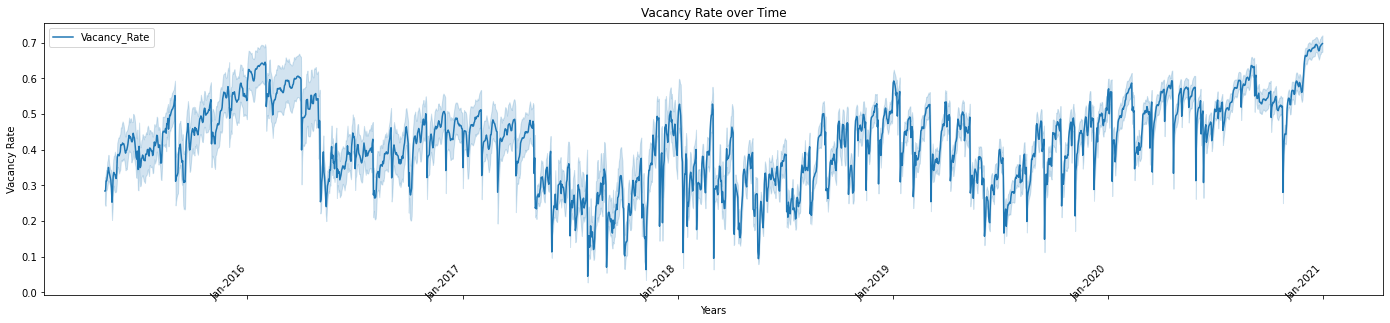

In [ ]:
#time series for main features - AirBnB
time_series_line_plots(['Vacancy_Rate'], df_zipcodes_final)

If we look at the graph above, the shape looks to follow the same cycle every year with slow increases and peaks seeming to be at almost every month's end with some noticeable increases towards the end of the year. This seems to corroborate the correlation analysis shown earlier that vacancy rate (see below) is strongly correlated with acres burned. It would be helpful for us to plot a seasonal graph to see how vacancy rate for every month of all the years we have changes to understand whether visually, there might be a seasonal expectation there.

For trends, there isn't a good way to see one given the five year window here. 2015 to 2016 indicates a good year for vendors with lower vacancy rates. However, the morning of 2018 looks to have higher vacancy rates. The middle to end is 2019 (toward the holiday season) seems to be the last hopeful time for AirBnB investors and property owners as it was right before COVID-19 made an entrance and changed everything as we know it. It is interesting however that towards the end of 2020, there was a dip in vacancy which shows some people were not in quarantine after all like we were all supposed to be.

Below, we look at whether there is any noticeable seasonality. A **point to note** throughout is that we have not checked to see whether any of the trends, seasonalities, or outliers we noticed are statistically significant changes as some of the learning required to check this is out of the scope of this class and our team's expertise.

In [ ]:
#cyclical graph

#### 2.1.3 Particle matter (PM 2.5)

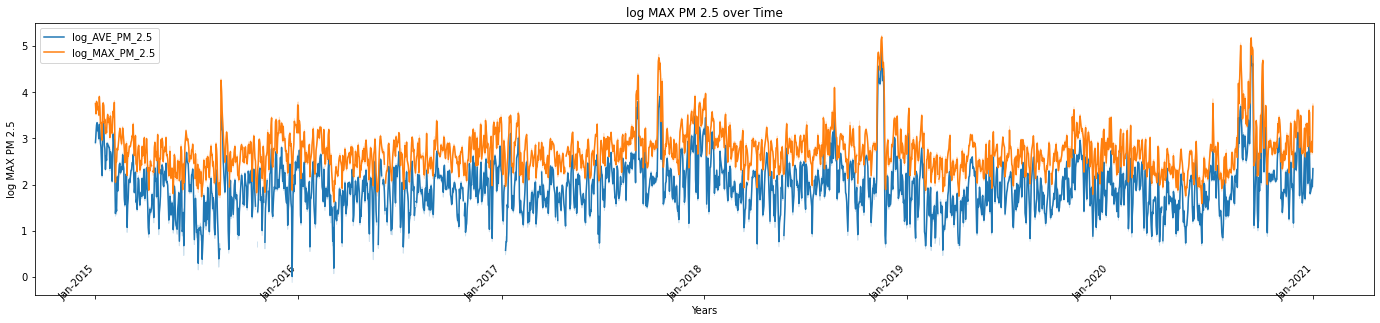

In [ ]:
#time series plot for main features -PM 2.5
PM_25_indicators = [x for x in df_zipcodes_final.columns if (x.find('PM_2.5') >= 0) & (x.find('log') >= 0)]
time_series_line_plots(PM_25_indicators, df_zipcodes_final)

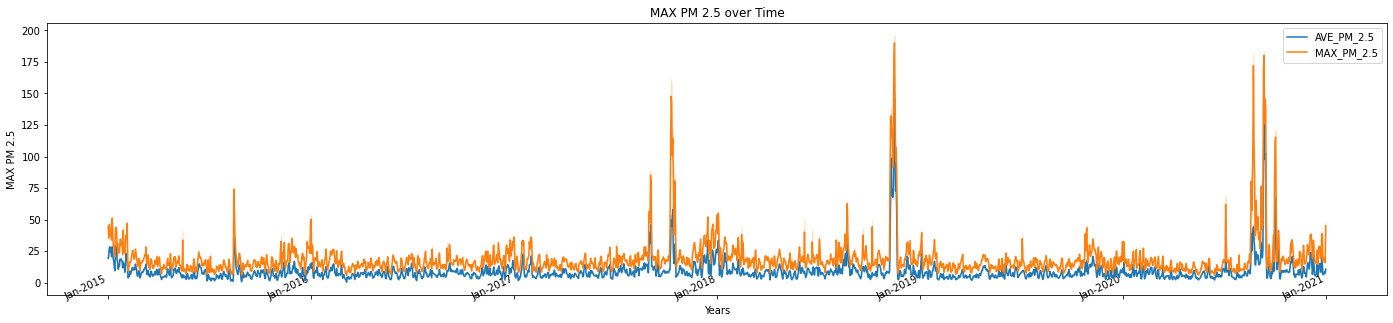

In [ ]:
PM_25_indicators = [x for x in df_zipcodes_final.columns if (x.find('PM_2.5') >= 0) & (x.find('log') == -1)]
time_series_line_plots(PM_25_indicators, df_zipcodes_final)

A note to remember for the particle matter indicator (in the first graph) is that we are looking at a log transform of the variable itself which therefore change the interpretation if we decide to use these variables in a model (or decide to create a model at all - we are still in the exploring stages!). The rate of change here also shows some slight similarities to how the wildfires occured. If you scroll up a little, you will notice that our transformed values tend to peak towards the end of the year and mirror the spikes (however small) on the acres burned and active wildfires graphs.

An interesting observation is that the spikes in PM2.5 in the atmosphere relative to number of wildfires or acres burned do not necessarily mirror each other. For instance, entering 2020 the acres burned chart indicated a lot of ashes in land covered out there, but the particulate matter measure is much higher entering 2019. This observation however goes hand in hand with the correlation table from earlier where these features had a small, weak positive correlation.

#### 2.1.4 Air Quality Index

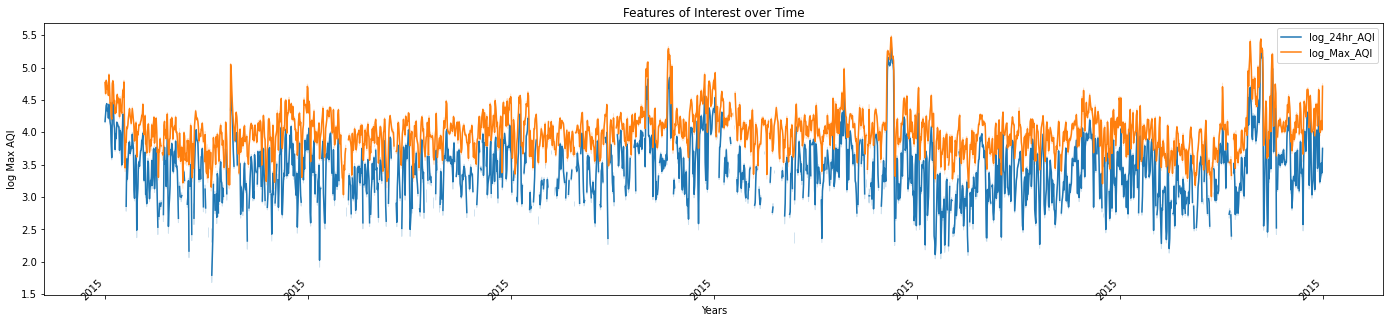

In [ ]:
#time series plot for main features - AQI
AQI_indicators = [x for x in df_zipcodes_final.columns if (x.find('AQI') >= 0) & (x.find('log') >= 0)]
time_series_plots(AQI_indicators, df_zipcodes_final)

**Some Takeaways:**

- AQI shows small increases trend over the last five years but we have not measured whether this is statistically significant (project scope at this stage)
- Some of the changes in AQI over the years mirror the wildfire prevalence indicating some sort of seasonality mostly correlated with wildfire season.
- AQI and particle matter spikes mirror each other (towards end of year/beginning of a new year) more closely which matches what we saw from the correlation figures earlier. This makes sense as we expect there to be changes in particle matter when the air quality changes.

### 2.2 Location Specific Observations

IF SOMEONE HAS TIME, WOULD BE NICE TO ADD SOME OF YOUR PLOTS HERE! Please and thank you!

### 2.3 Relationships between Features

IF SOMEONE HAS TIME, WOULD BE NICE TO ADD SOME OF YOUR PLOTS HERE! Please and thank you!

## Investigating Flights Data

We now want to explore the data for airports and flights in the Bay Area, including possible correlations between these data and wildfires/air quality, as well as any interesting features in the most common departure and arrival airports over time. 

In [ ]:
# flights/airports data
df_flights = pd.read_csv(path+'aggregated_by_departure.csv')

In [ ]:
# Calculating correlations between various flights and wildfires/air quality fields

flights_fields = ['PASSENGERS', 'MEDIAN_ITIN_FARE']

for i in flights_fields:
    print('Correlation between median ' + i + ' and median acres burned per day: ',
          df_flights.groupby('QQ-YYYY')[i].median().corr(df_zipcodes_final.groupby('QUARTER')['Acres_per_day'].median()))
    print('Correlation between median ' + i + ' and number of active fires: ',
          df_flights.groupby('QQ-YYYY')[i].median().corr(df_zipcodes_final.groupby('QUARTER')['Active_wildfires'].count()))
    print('Correlation between median ' + i + ' and median PM2.5 value: ',
          df_flights.groupby('QQ-YYYY')[i].median().corr(df_zipcodes_final.groupby('QUARTER')['AVE_PM_2.5'].median()))
    
# Question: should we be using a correlation other than the default Pearson's?? 

We see some potentially interesting correlations between passengers/acres burned, passengers/active fires, itinerary fare/active fires, and itinerary fare/PM2.5 values. This may be an indication that passengers are less willing to travel to the Bay Area during times when wildfires are most active (unsurprisingly), but also that fires and poor air quality may be related to the cost of flights.